In [1]:
from setup_notebook import set_path_to_root

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import zscore
import seaborn as sns

from data.database import GrandExchangeDB
from data.preprocess import (
    load_price_data,
    remove_price_outliers
)

In [2]:
prices = load_price_data()

Local DB found, checking for updated data...
Progress 0/10
Progress 1/10
Progress 2/10
Progress 3/10
Progress 4/10
Progress 5/10
Progress 6/10
Progress 7/10
Progress 8/10
Progress 9/10
Latest price data loaded, 10 new timesteps saved


Select items which have on average more than 1m sold each hour

In [3]:
prices.head()

,item_id,datetime,name,price,margin,volume
0,2,2022-01-01,Cannonball,165.5,5.0,700619.0
1,62,2022-01-01,Maple longbow (u),75.5,3.0,10699.0
2,66,2022-01-01,Yew longbow (u),333.5,5.0,52181.0
3,70,2022-01-01,Magic longbow (u),1023.5,5.0,16828.0
5,97,2022-01-01,Harralander potion (unf),840.5,37.0,1934.0


In [4]:
def plot_single_item_prices(item_id, **kwargs):
    df = prices[prices['item_id'] == item_id].copy()
    item_name = df['name'].unique()[0] + ' prices'
    sns.set(rc={'figure.figsize':(15, 7)})
    ax = sns.lineplot(data=df, x='datetime', y='price', color='blue', alpha=0.5)
    ax.set_title(item_name)
    plt.fill_between(df.datetime, df['price'] - df['margin'], df['price'] + df['margin'], color='grey', alpha=0.5)

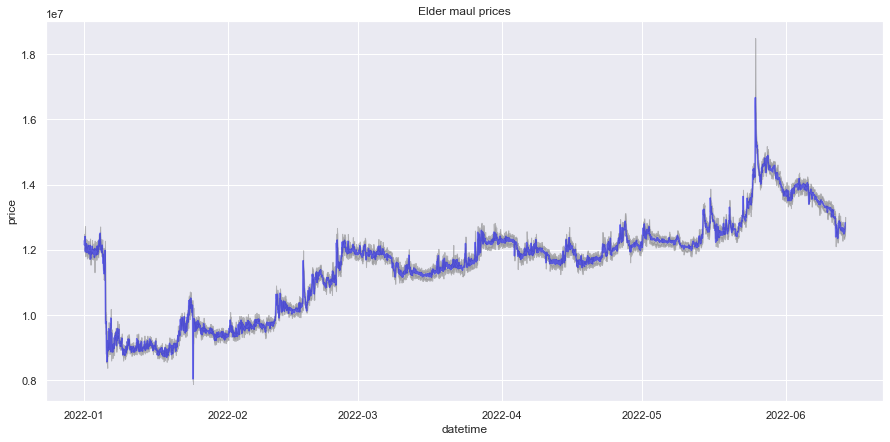

In [6]:
plot_single_item_prices(21003)

### Detect and remove outliers

A number of items seem to have a few outliers in the prices data.

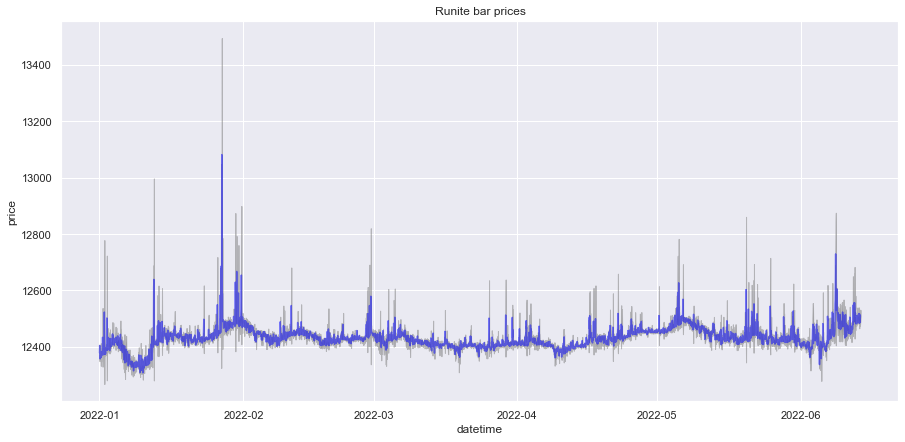

In [7]:
plot_single_item_prices(2363)

In [ ]:
df = prices[prices['item_id'] == 2363].copy()
df['price_change'] = df.sort_values('datetime')['price'].diff()
df.loc[df['price_change'].isna(), 'price_change'] = 0

In [ ]:
sns.histplot(df['price_change'], bins=500)

Difference is normally distributed - use z scores to remove outliers

In [ ]:
df['zscore'] = zscore(df['price_change'])
anomalies = df[df['zscore'] > 5][['item_id', 'datetime']]
anomalies['anomalous'] = 1

df = pd.merge(df, anomalies, on=['item_id', 'datetime'], how='left')
df.loc[df['anomalous'].isna(), 'anomalous'] = 0

plt.plot(df['datetime'], df['price'])
plt.scatter(df.loc[df['anomalous'] == 1, 'datetime'], df.loc[df['anomalous'] == 1, 'price'], color='red', label='removed points')
plt.legend()
plt.show()

In [ ]:
prices = remove_price_outliers(prices)

### Impute missing periods

In [ ]:
df = prices.copy()

# Get all periods in the dataset
all_periods = df[['datetime']].drop_duplicates().reset_index(drop=True)

### DTW find similar clusters of items

In [ ]:
import tslearn

In [ ]:
df = prices.copy()

# Standardize prices by group
df['price_scaled'] = df.groupby('item_id')['price'].transform(lambda x: (x - x.mean()) / x.std())

In [ ]:
sns.lineplot(data=df, x='datetime', )

In [ ]:
df

### Add useful stock feature

### Test multivariate forecasting?

In [ ]:
plot_single_item_prices(2363)

In [ ]:
df = prices[prices['item_id'] == 2363].copy()
df['price_change'] = df.sort_values('datetime')['price'].diff()
df.loc[df['price_change'].isna(), 'price_change'] = 0

In [ ]:
sns.histplot(df['price_change'])

Difference is normally distributed - use z scores to remove outliers

**Add a single measure for price and volume traded**
- **Price**: take the average of high and low price
- **Volume**: Take the sum of high/low traded volume
- **Margin**: the difference between high and low prices at that timestep

Can we detect any time-series outliers?

### Analysis

1. How many items?
1. Distribution of average prices (all items)
1. Distribution of variability (stddev)
1. Plots of margin against price over time
1. Ratio of price to amount traded (scatter)


### DTW find similar clusters of items

### Add useful stock feature

### Test multivariate forecasting?